In [29]:
from torch.utils.data import Dataset

import torchaudio
import os
from torch.utils.data import DataLoader
import torch
import numpy as np

import torch.nn as nn


import matplotlib.pyplot as plt

import tqdm


from os.path import abspath, dirname, join


In [2]:
AUDIO_DIR = "D:\\units\\PML\\project\\mic_dev_splits\\"
SAMPLE_RATE = 48000
DEVICE = 'cpu'

In [6]:
class SoundDataset(Dataset):

    def __init__(self, audio_dir, target_sample_rate, folder):
        self.audio_dir = audio_dir
        #self.transformation = transformation
        self.target_sample_rate = target_sample_rate/10
        self.folder = folder
        self.file_names = []
        self.labels = []
        #initialize lists to hold file names, labels, and folder numbers
        for filename in os.listdir(audio_dir + folder):
            self.file_names.append(filename)
            self.labels.append(int(filename.split("_")[2]))

    def __len__(self):
        return len(self.file_names)



    # a_list[1] --> a__list.__getitem__(1)
    def __getitem__(self, index):
        audio_sample_path = self._get_audio_sample_path(index)

        #label associated with this sample path
        ls = self.file_names[index].split("_")
        label = int(ls[2])
        signal, sample_rate = torchaudio.load(audio_sample_path) # not all files have the same sample rate
        # signal -> (num_channels, samples) -> (2, 16000) -> (1,1600)
        signal = self._resample_if_necessary(signal, sample_rate)
        signal = self._mix_down_if_necessary(signal)
        
        
        return signal, label

    def _get_audio_sample_path(self, index):
        path = os.path.join(self.audio_dir, self.folder, self.file_names[index])
        return path

    def _get_audio_sample_label(self, index):
        label = self.labels[index]
        label = np.asarray(label)   
        return torch.from_numpy(label.astype('long'))

    def _resample_if_necessary(self, signal, sr):
        if sr > self.target_sample_rate:
            resampler = torchaudio.transforms.Resample(sr, self.target_sample_rate)
            signal = resampler(signal)
        if signal.shape != torch.Size((1, 32000)):
            signal = nn.ConstantPad1d((0, 32000 - signal.shape[1]), 0)(signal)

        return signal

    def _mix_down_if_necessary(self, signal):
        if signal.shape[0] > 1:
            signal = torch.mean(signal, dim=0, keepdim=True)
        return signal

In [7]:
train_set = SoundDataset( AUDIO_DIR,  SAMPLE_RATE, "train")
test_set = SoundDataset(AUDIO_DIR, SAMPLE_RATE, "test")

print("Train set size: " + str(len(train_set)))
print("Test set size: " + str(len(test_set)))

Train set size: 59
Test set size: 14


Shape of waveform: torch.Size([1, 155520]) audio: phone_-10_170_60.wav


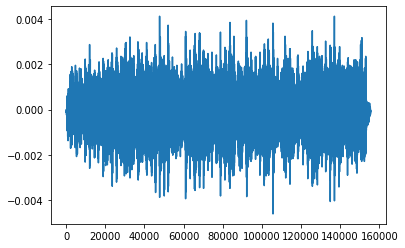

In [8]:
fold = f"test"
path = os.path.join(AUDIO_DIR, fold, 'phone_-10_170_60.wav')

signal, sample_rate = torchaudio.load(path) # not all files have the same sample rate
print(f"Shape of waveform: {signal.size()} audio: phone_-10_170_60.wav")

plt.plot(signal.t().numpy())


Shape of waveform: torch.Size([1, 32000]) audio: phone_-10_170_60.wav


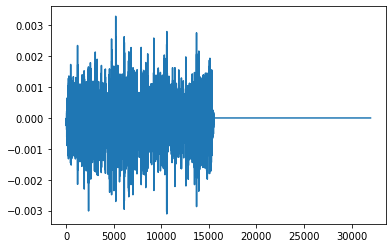

In [9]:
waveform, label = test_set[0]
print(f"Shape of waveform: {waveform.size()} audio: phone_-10_170_60.wav")
plt.plot(waveform.t().numpy())

In [10]:
if DEVICE == "cuda":
    num_workers = 1
    pin_memory = True
else:
    num_workers = 0
    pin_memory = False

In [33]:
train_loader = DataLoader(train_set, batch_size=8, shuffle=True)
test_loader = DataLoader(train_set, batch_size=8, shuffle=True)


In [14]:
!pip3 install gpytorch

     -------------------------------------- 353.6/353.6 kB 1.8 MB/s eta 0:00:00


In [34]:
import gpytorch as gpy

In [35]:
train_x, train_y = next(iter(train_loader))
test_x, test_y = next(iter(test_loader))
print(test_x[0].shape)

torch.Size([1, 32000])


In [36]:
class GPModel(gpy.models.ApproximateGP):
    def __init__(self, inducing_points):
        variational_distribution = gpy.variational.CholeskyVariationalDistribution(inducing_points.size(0))
        variational_strategy = gpy.variational.VariationalStrategy(self, inducing_points, variational_distribution, learn_inducing_locations=True)
        super(GPModel, self).__init__(variational_strategy)
        self.mean_module = gpy.means.ConstantMean()
        self.covar_module = gpy.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpy.distributions.MultivariateNormal(mean_x, covar_x)

inducing_points = train_x[:100, :]
model = GPModel(inducing_points=inducing_points)
likelihood = gpy.likelihoods.GaussianLikelihood()

if torch.cuda.is_available():
    model = model.cuda()
    likelihood = likelihood.cuda()

In [37]:
num_epochs = 4


model.train()
likelihood.train()

optimizer = torch.optim.Adam([
    {'params': model.parameters()},
    {'params': likelihood.parameters()},
], lr=0.01)

# Our loss object. We're using the VariationalELBO
mll = gpy.mlls.VariationalELBO(likelihood, model, num_data=train_y.size(0))


epochs_iter = tqdm.notebook.tqdm(range(num_epochs), desc="Epoch")
for i in epochs_iter:
    # Within each iteration, we will go over each minibatch of data
    minibatch_iter = tqdm.notebook.tqdm(train_loader, desc="Minibatch", leave=False)
    for x_batch, y_batch in minibatch_iter:
        optimizer.zero_grad()
        output = model(x_batch)
        loss = -mll(output, y_batch)
        minibatch_iter.set_postfix(loss=loss.item())
        loss.backward()
        optimizer.step()

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

RuntimeError: mat1 and mat2 shapes cannot be multiplied (8x1 and 8x1)